In [1]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from math import sqrt

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import seaborn as sns


sns.set_theme(style="whitegrid")

# Functions

## Read in data

In [2]:
def prep_wrf_data(fpath, var_name_dict, site):
    df = pd.read_pickle(fpath)
    #df['air temperature (C)'] = df['air temperature (C)'] - 273  # Convert C to K
    #df.index = df.index - pd.Timedelta(hours = 8)  # UTC to PST
    #df = get_wind(df)  # Calc wind direction/speed
    df.rename(columns=var_name_dict, inplace=True)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'wrf'
    
    return df

def prep_obs_data(fpath, site):
    df = pd.read_csv(fpath, index_col='time (PST)')
    df.index = pd.to_datetime(df.index)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'obs'
    
    return df

## Run calculations

In [3]:
def run_stats(df, var, site):
    # Subset to site and var
    df = df.loc[df['site'] == site]

    # Define validation/model data
    xval = df.loc[df['source']=='obs'][var].rename('val')
    ymod = df.loc[df['source']=='wrf'][var].rename('model')
    
    # Inner join
    df = pd.concat([xval, ymod], axis=1, join='inner')
    df.dropna(inplace=True)
    xval = df['val']
    ymod = df['model']
    
    # Calculate stats
    res = np.corrcoef(xval, ymod)
    corr = res[0,1]
    bias = (ymod - xval).mean()
    tmp = (ymod - xval)**2
    rmse = np.sqrt(tmp.mean())
    mabs = np.abs(ymod - xval).mean()
    # Return results
    results = { 
        'site' : [site],
        'variable' : [var],
        'correlation' : [round(corr, 2)],
        'bias' : [round(bias, 2)],
        'rmse' : [round(rmse, 2)],
        'mae' : [round(mabs, 2)]
    }
    
    df = pd.DataFrame(results)
    return df

## Plotting functions

In [45]:
def plot_stats(df, metric):
    g = sns.catplot(
        data=stats_df, kind="bar",
        x="variable", y=metric, hue="site",
        palette="tab10", alpha=.6, height=8
    )
    g.set_axis_labels("", metric)

    g.legend.set_title("")
    g.set(title=metric)
    
    # Add value labels
    ax = g.ax  # Get the matplotlib axis
    for bar in ax.patches:  # Iterate through the bars
        bar_height = bar.get_height()  # Get bar height
        bar_x = bar.get_x() + bar.get_width() / 2.0  # Get bar x position
        ax.text(bar_x, bar_height, f'{bar_height:.2f}', 
                ha='center', va='bottom', fontsize=10)
    
    plt.show()

    
def plot_cdf(df, var_list, site):
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    df = df.loc[df['site'] == site]
    idx = 0
    
    # make plots
    for row in [0,1]:
        for col in [0,1]:
            sns.ecdfplot(data=df.loc[df['source']=='wrf'], x=var_list[idx], ax=ax[row,col], color='blue', label='WRF')
            sns.ecdfplot(data=df.loc[df['source']=='obs'], x=var_list[idx], ax=ax[row,col], color='orange', label='Observed')
            idx+=1
    
    # make legend
    for axes in ax.flat:
        legend = axes.get_legend()
        if legend is not None:
            legend.remove()

    fig.legend(['WRF', 'Observed'], loc='center left', bbox_to_anchor=(1.05, 0.5), title='Source')
    fig.tight_layout(rect=[0, 0, 1, .97])
    
    fig.suptitle(site)
    

    plt.show()
    
def plot_scatter(df, var_list, site):
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    df = df.loc[df['site'] == site]
    idx=0
      
    for row in [0,1]:
        for col in [0,1]:
            # Join to drop missing
            x=df.loc[df['source']=='obs'][var_list[idx]].rename('obs')
            y=df.loc[df['source']=='wrf'][var_list[idx]].rename('model')
            join_df = pd.concat([x,y], axis=1, join='inner')

            # Plot
            ax[row, col].scatter(x=join_df['obs'],
                                 y=join_df['model'],
                                 alpha=0.25)
            ax[row,col].axline((1, 1), slope=1, color='black', linestyle='--')

            ax[row,col].set(xlabel='Observed',
                            ylabel='WRF',
                            title=f'{site} {var_list[idx]}')
            ax[row, col].axis('equal')
            idx+=1
            
    fig.tight_layout(rect=[0, 0, .97, .97])
    fig.suptitle(site)
    
    plt.show()
    

def plot_timeseries(df, raw_df, var, daterange, site):
    df = df.loc[df['site']==site]
    raw_df = raw_df.loc[raw_df['site']==site]
    wdf = df.loc[df['source'] == 'wrf']
    odf = df.loc[df['source'] == 'obs']
    
    wdf = wdf[daterange[0] : daterange[1]]
    odf = odf[daterange[0] : daterange[1]]
    raw_df = raw_df[daterange[0] : daterange[1]]
    
    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(20,6))

    ax.plot(odf.index, odf[var], color='orange', label=f'Obs {var}')
    ax.plot(raw_df.index, raw_df[var], color='lightblue', label=f'WRF raw {var}', alpha=1, linestyle="--")
    ax.plot(wdf.index, wdf[var], color='blue', label=f'WRF QM {var}', alpha=0.7)

    fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

    ax.set(title=f'Model vs. Observational {var}\n {site} {month}/{year}',
           ylabel=f'{var}')

    plt.show()

    

# Overall Agreement

## Read in and Prepare Data

In [5]:
var_name_dict = {
    'DFGDP' : 'fog drip',
    'T2' : 'air temperature (C)',
    'RH' : 'relative humidity (%)',
    'WND_SPD' : 'wind speed (m/s)',
    'WND_DIR' : 'wind direction (deg)'
}

#### WRF file paths ####
wdatadir = '/home/patmccornack/data/wrf_extracted/quantile_mapped'
wsauc_fname = 'wrf_sauc_2003-2010.pkl'
wupem_fname = 'wrf_upem_2003-2010.pkl'
wnrs_sci_fname = 'wrf_nrs_sci_2014-2019.pkl'

#### Obs file paths ####
odatadir = '/home/patmccornack/data/preprocessed'
osauc_fname = 'SAUC_hourly.csv'
oupem_fname = 'UPEM_hourly.csv'
onrs_sci_fname = 'NRS_SCI_hourly.csv'

#### Read in data ####
wsauc = prep_wrf_data(os.path.join(wdatadir, wsauc_fname), var_name_dict, site='Sauces Canyon')
wupem = prep_wrf_data(os.path.join(wdatadir, wupem_fname), var_name_dict, site='Upper Embudo Canyon')
wnrs_sci = prep_wrf_data(os.path.join(wdatadir, wnrs_sci_fname), var_name_dict, site='NRS SCI')

osauc = prep_obs_data(os.path.join(odatadir, osauc_fname), site='Sauces Canyon')
oupem = prep_obs_data(os.path.join(odatadir, oupem_fname), site='Upper Embudo Canyon')
onrs_sci = prep_obs_data(os.path.join(odatadir, onrs_sci_fname), site='NRS SCI')

In [6]:
wsauc.head()

air temperature (C)  relative humidity (%)  \
times                                                             
2002-06-30 16:00:00            14.957162              94.710423   
2002-06-30 17:00:00            17.350040              86.784691   
2002-06-30 18:00:00            17.201944              89.554658   
2002-06-30 19:00:00            15.840531              88.230378   
2002-06-30 20:00:00            14.074515              93.338573   

                     wind speed (m/s)  wind direction (deg)  
times                                                        
2002-06-30 16:00:00          0.919070            214.075183  
2002-06-30 17:00:00         -0.677735            146.514948  
2002-06-30 18:00:00          0.546559            323.129009  
2002-06-30 19:00:00          0.660989            323.746555  
2002-06-30 20:00:00          0.467123            328.070915

In [7]:
# Join all into a single dataframe
df_list = [wsauc, wupem, wnrs_sci, osauc, oupem, onrs_sci]
for df in df_list:
    df['site'] = df.attrs['site']
    df['source'] = df.attrs['source']

df = pd.concat(df_list, join='inner', axis=0)
df.head(2)

air temperature (C)  relative humidity (%)  \
2002-06-30 16:00:00            14.957162              94.710423   
2002-06-30 17:00:00            17.350040              86.784691   

                     wind speed (m/s)  wind direction (deg)           site  \
2002-06-30 16:00:00          0.919070            214.075183  Sauces Canyon   
2002-06-30 17:00:00         -0.677735            146.514948  Sauces Canyon   

                    source  
2002-06-30 16:00:00    wrf  
2002-06-30 17:00:00    wrf

In [8]:
variables = ['air temperature (C)', 'relative humidity (%)', 'wind speed (m/s)', 'wind direction (deg)']
sites = ['Sauces Canyon', 'Upper Embudo Canyon', 'NRS SCI']

## Statistics

In [43]:
stats_df = pd.DataFrame()
for site in sites:
    for variable in variables:
        tmp = run_stats(df, variable, site)
        stats_df = pd.concat([stats_df, tmp], axis=0)

stats_df['type'] = 'quantile mapped'
stats_df.to_csv('~/data/wrf_extracted/comparison_stats/wrf_qm_stats.csv')
stats_df

site               variable  correlation  bias    rmse  \
0        Sauces Canyon    air temperature (C)         0.87  0.13    2.42   
0        Sauces Canyon  relative humidity (%)         0.84 -0.05   14.27   
0        Sauces Canyon       wind speed (m/s)         0.58 -0.07    1.28   
0        Sauces Canyon   wind direction (deg)         0.55  4.48   90.51   
0  Upper Embudo Canyon    air temperature (C)         0.89 -0.16    2.69   
0  Upper Embudo Canyon  relative humidity (%)         0.85 -1.84   15.86   
0  Upper Embudo Canyon       wind speed (m/s)         0.64  0.01    0.94   
0  Upper Embudo Canyon   wind direction (deg)         0.62 -3.10   78.22   
0              NRS SCI    air temperature (C)         0.90  0.06    2.40   
0              NRS SCI  relative humidity (%)         0.82 -0.22   16.19   
0              NRS SCI       wind speed (m/s)         0.61 -0.01    1.92   
0              NRS SCI   wind direction (deg)         0.25  8.35  133.29   

     mae             type  
0   1.75  quantile mapped  
0   9.90  quantile mapped  
0   0.95  quantile mapped  
0  47.92  quantile mapped  
0   1.99  quantile mapped  
0  10.97  quantile mapped  
0   0.70  quantile mapped  
0  49.29  quantile mapped  
0   1.81  quantile mapped  
0  11.37  quantile mapped  
0   1.48  quantile mapped  
0  93.23  quantile mapped

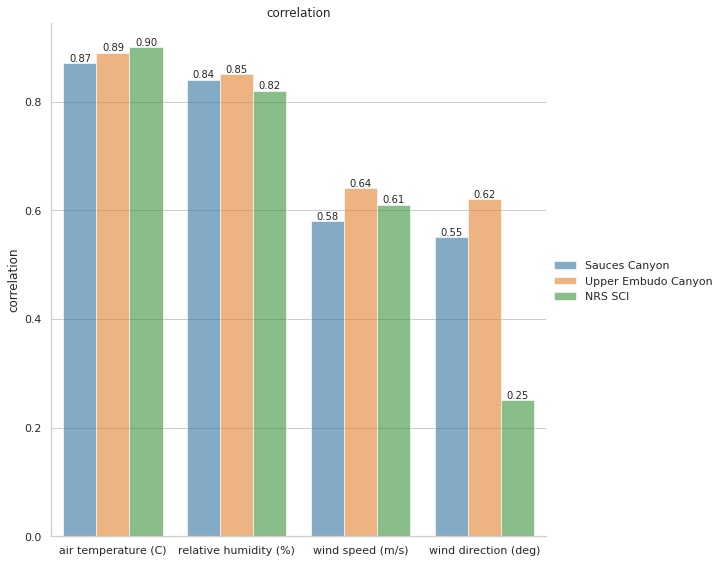

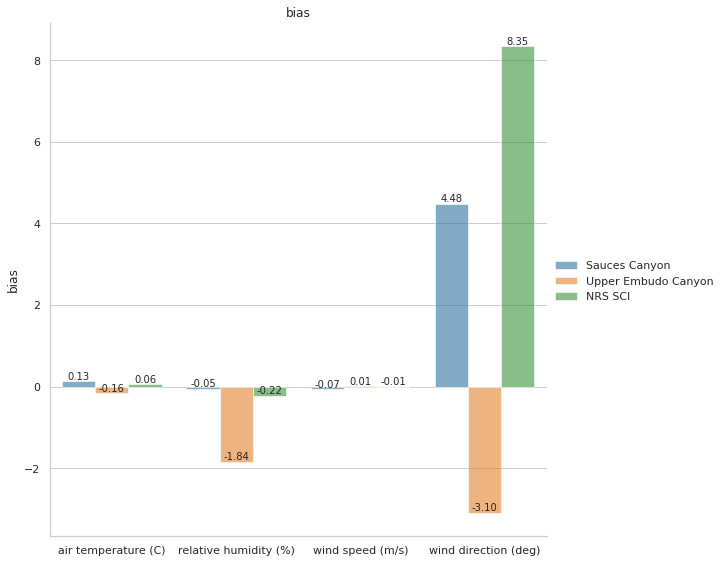

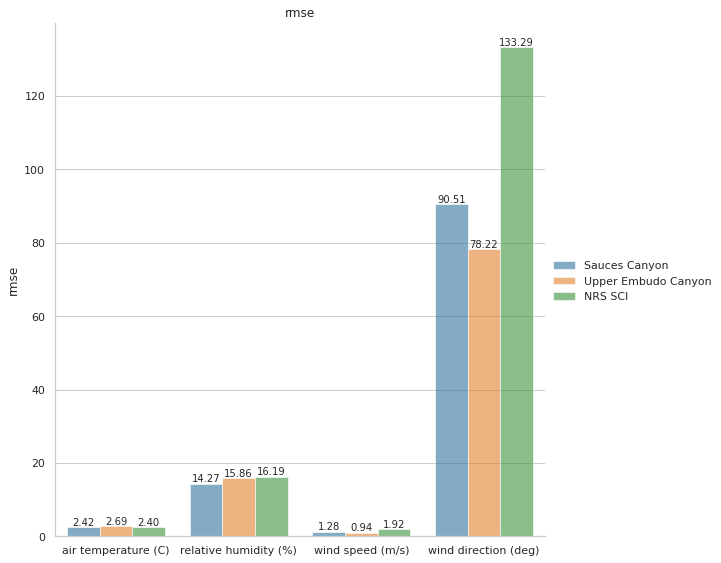

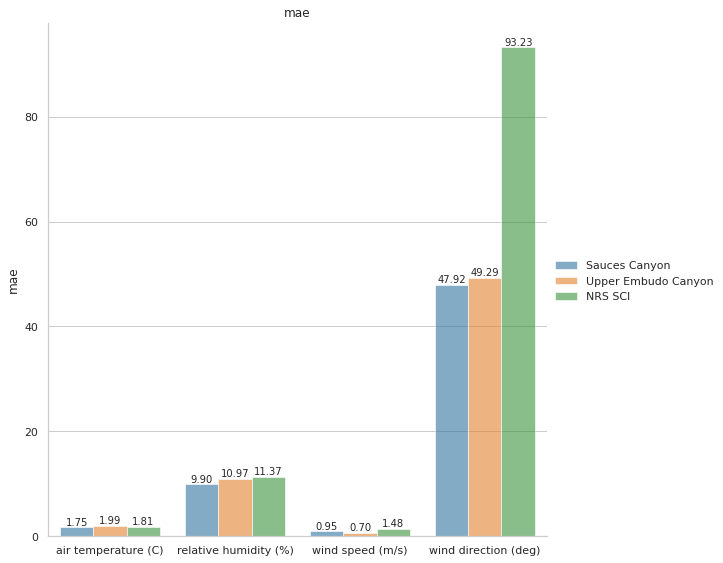

In [ ]:
for metric in ['correlation', 'bias', 'rmse', 'mae']:
    plot_stats(df, metric)

## CDF Plots

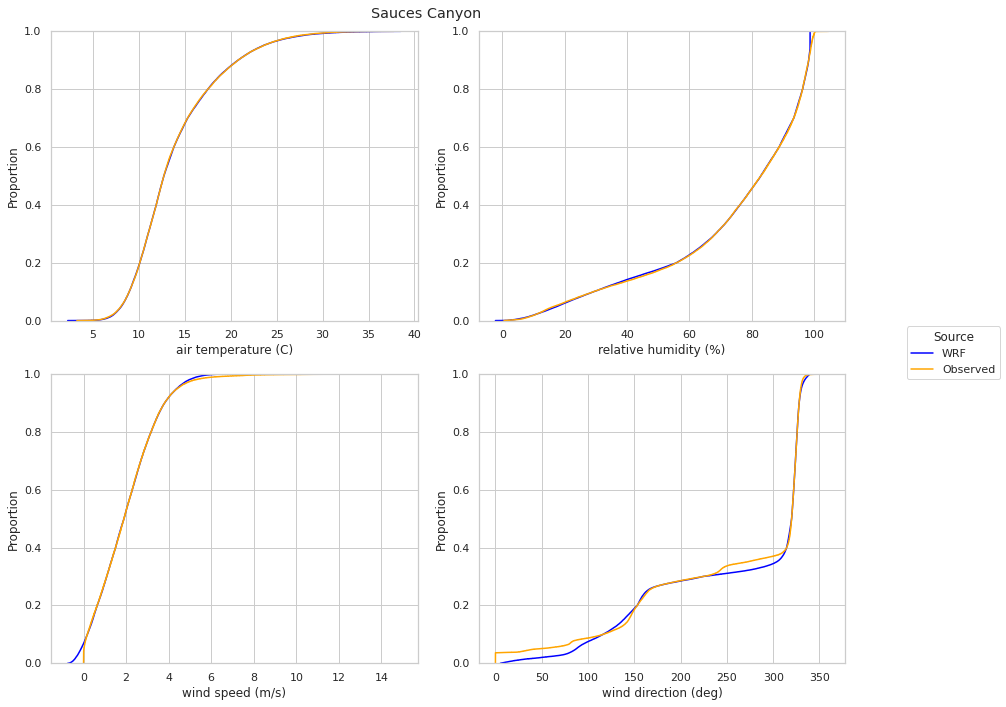

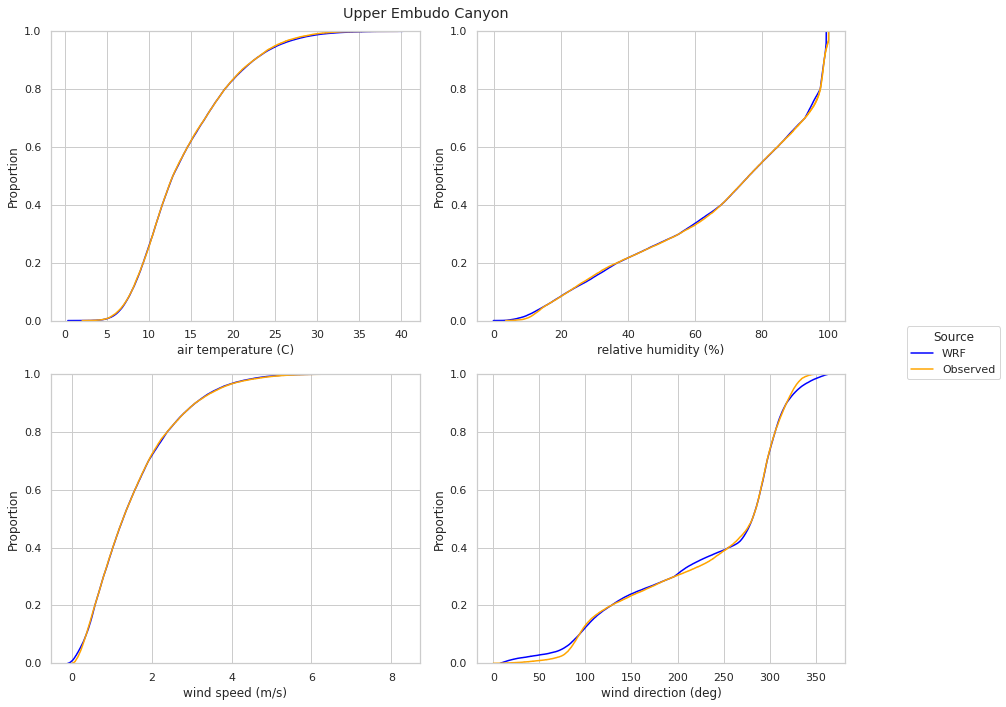

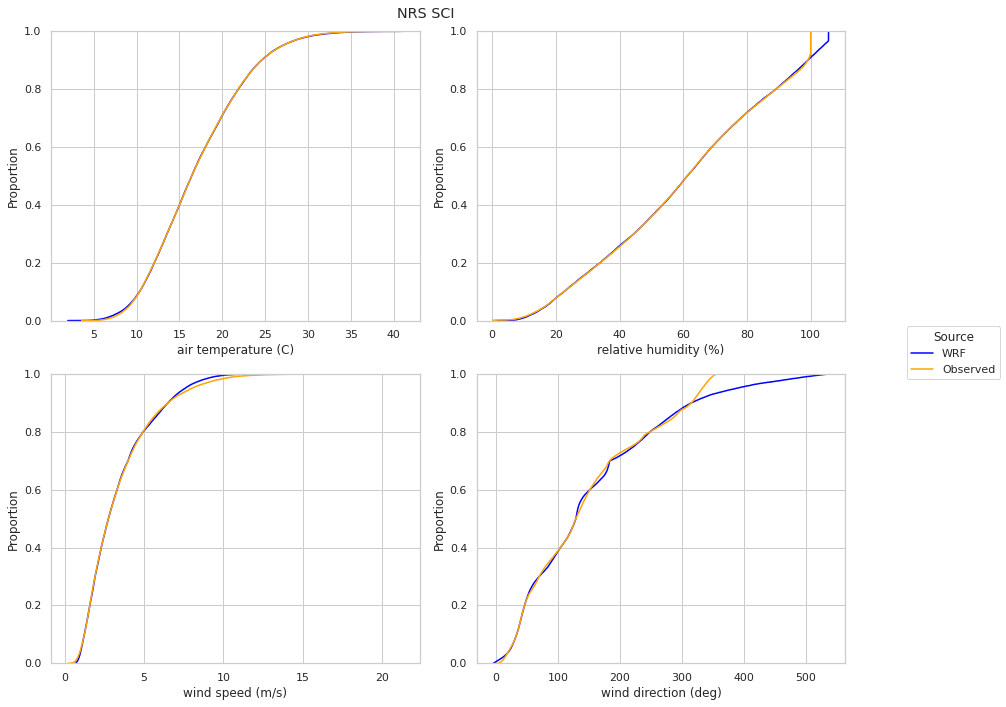

In [11]:
  for site in sites:
    plot_cdf(df, variables, site)


## Scatter Plots

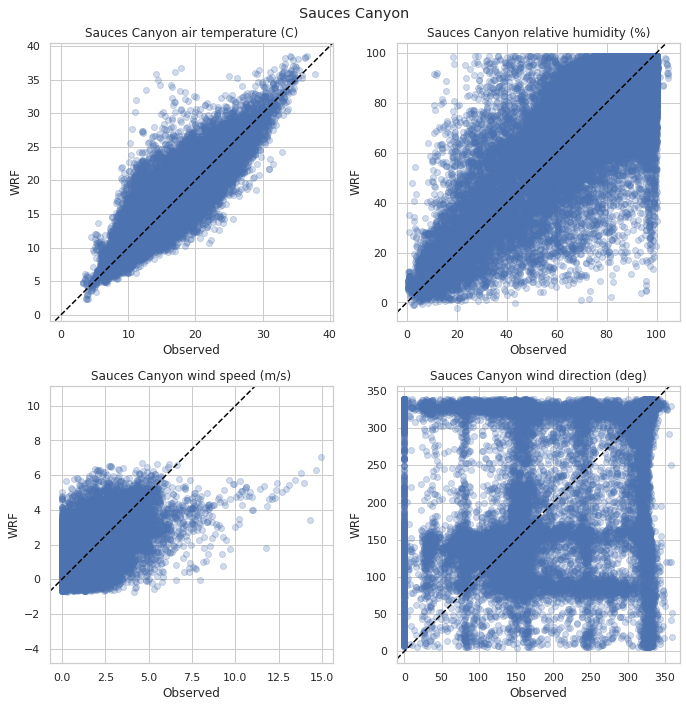

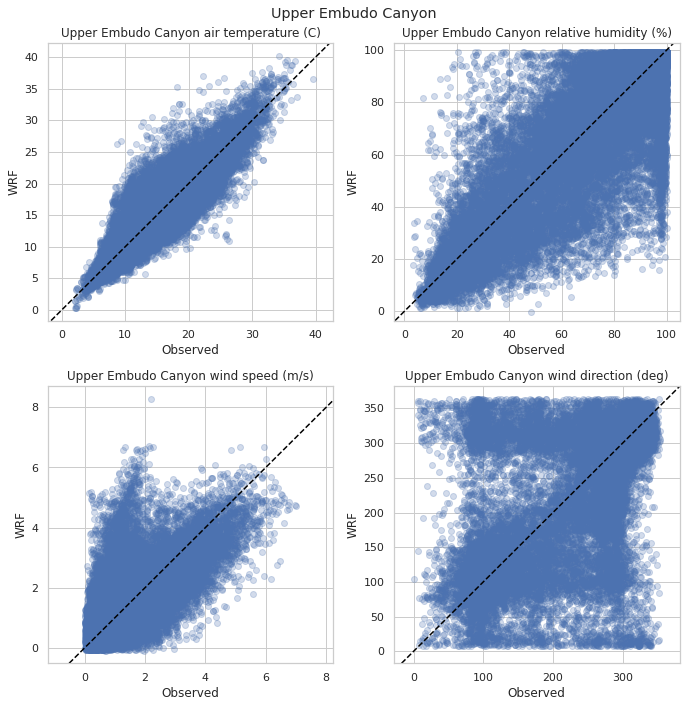

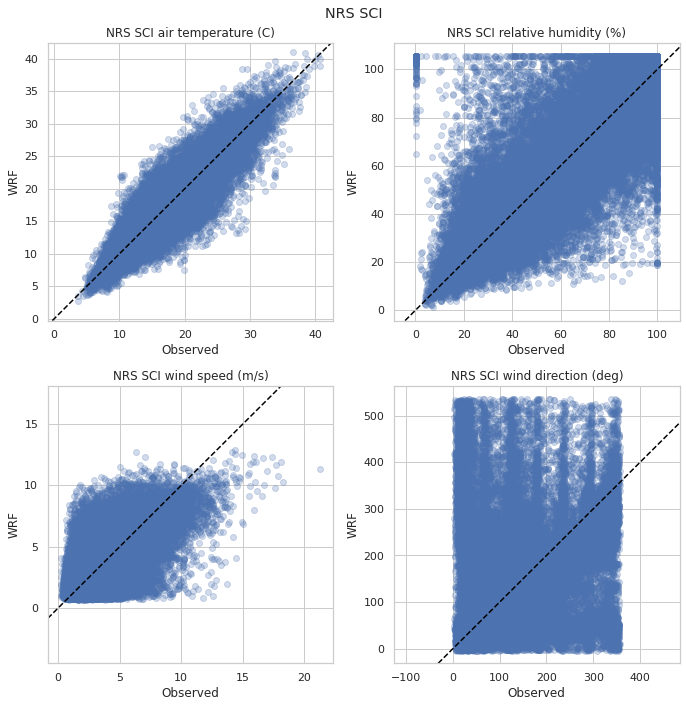

In [12]:
for site in sites:
    plot_scatter(df, variables, site)

## Time Series Plots
Compared with raw WRF data

In [32]:
# Read in raw WRF data
raw_df = pd.read_pickle(os.path.join(wdatadir, "raw_wrf_data.pkl"))              

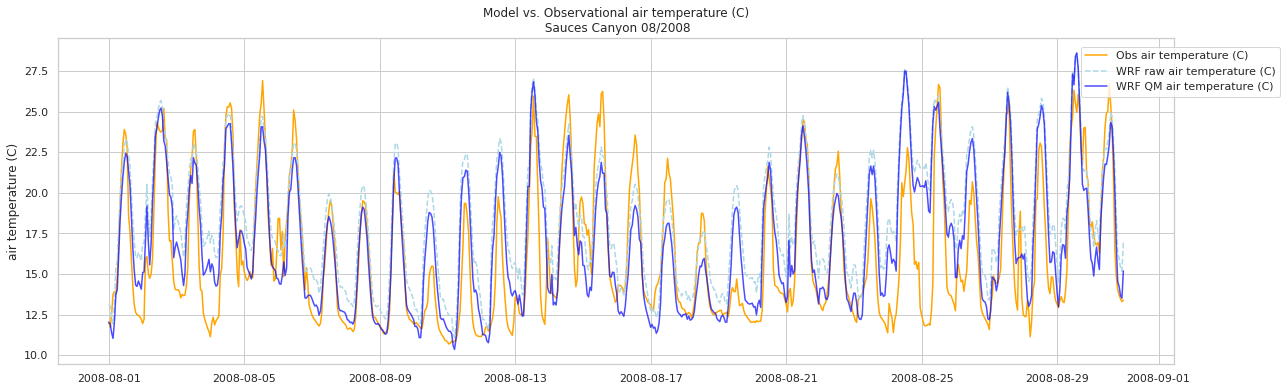

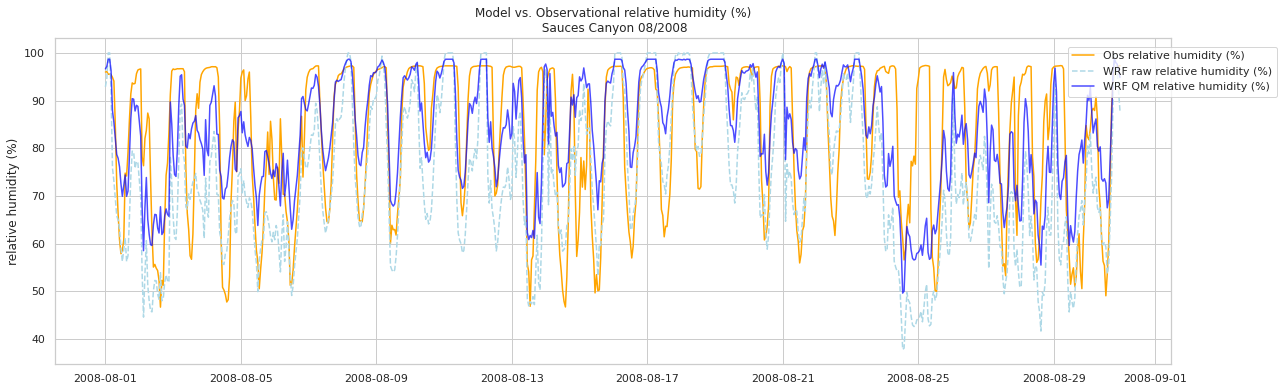

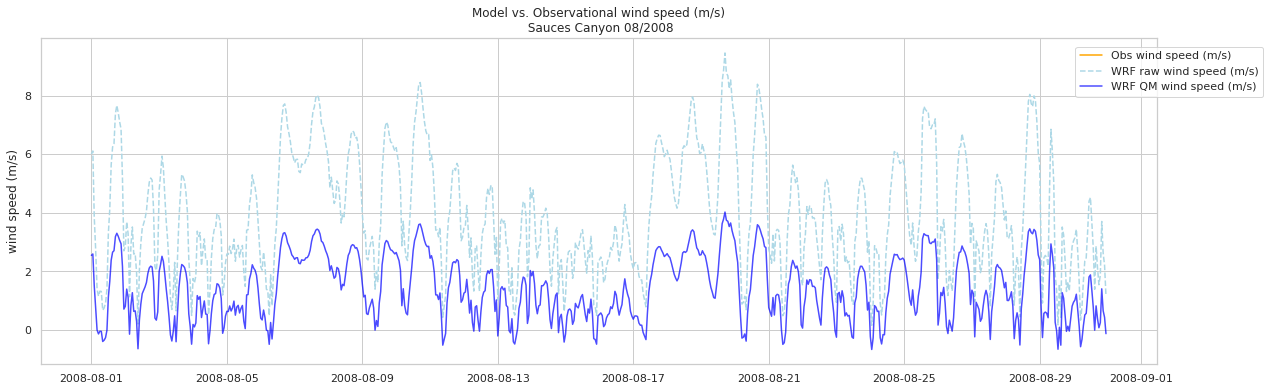

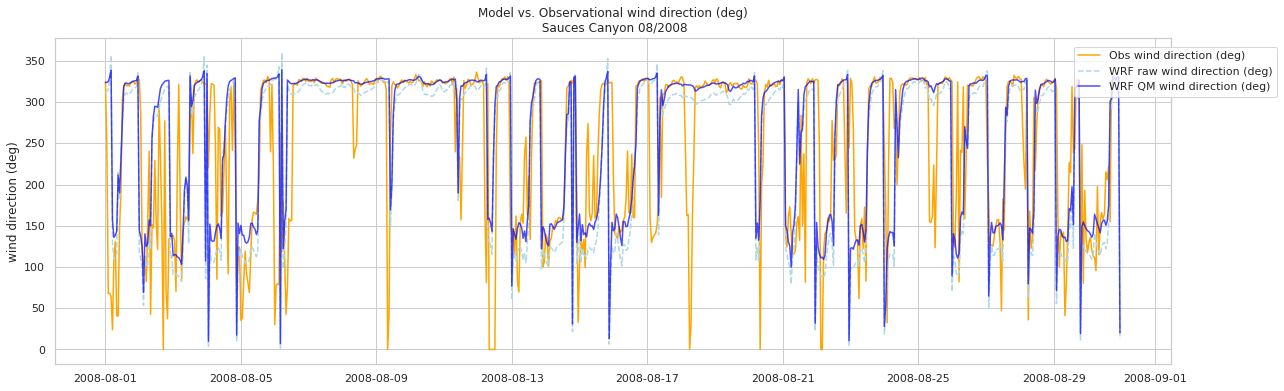

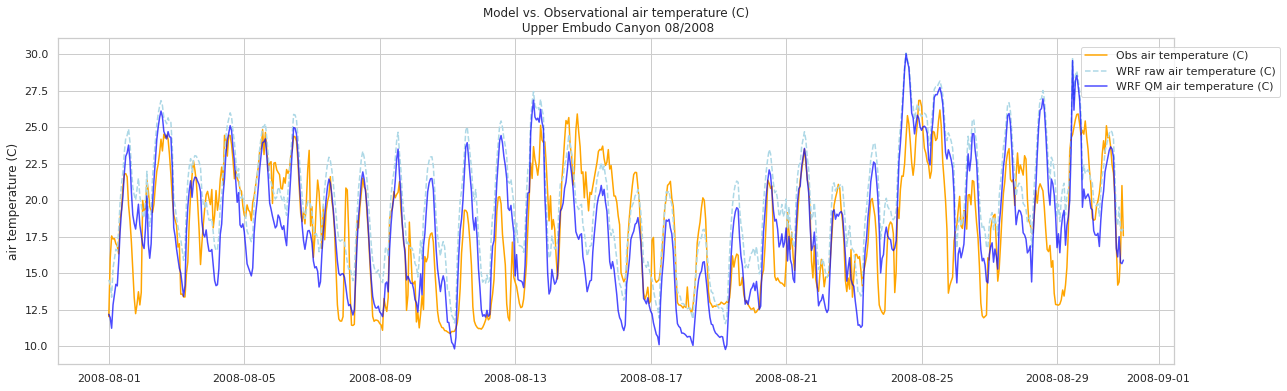

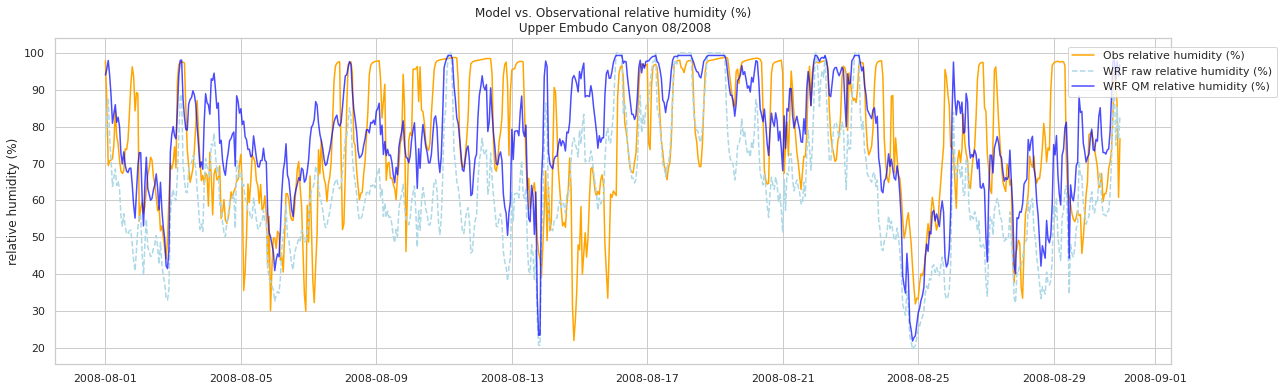

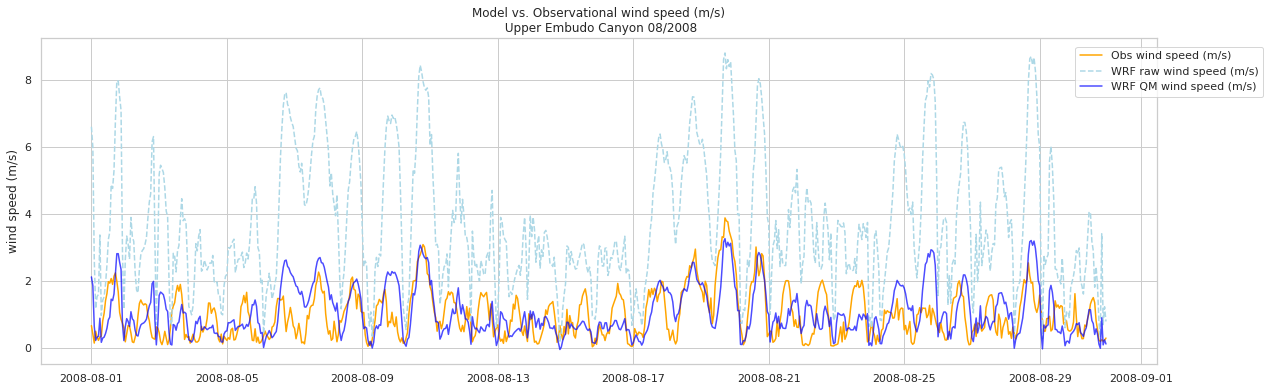

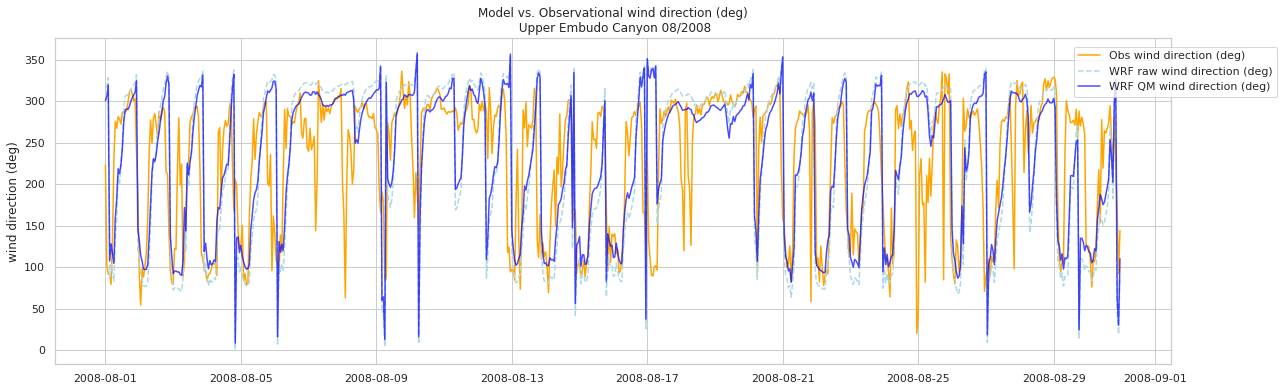

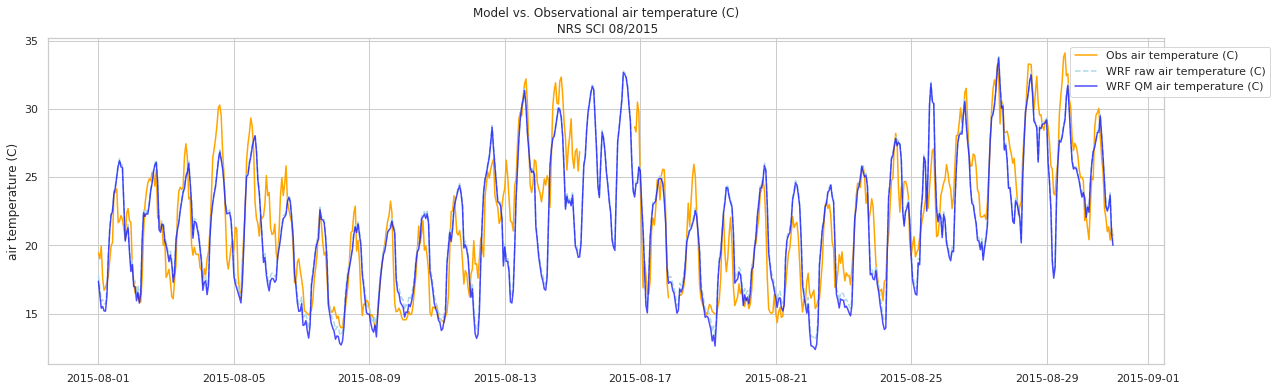

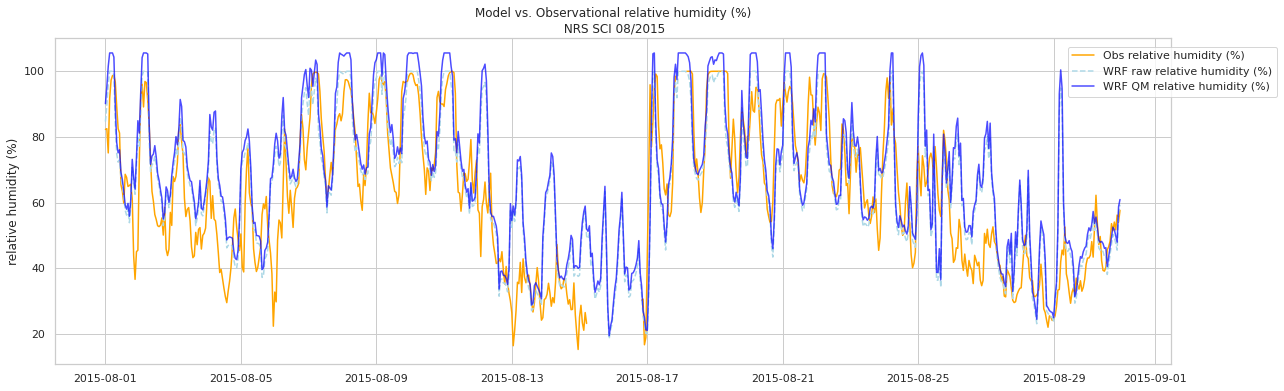

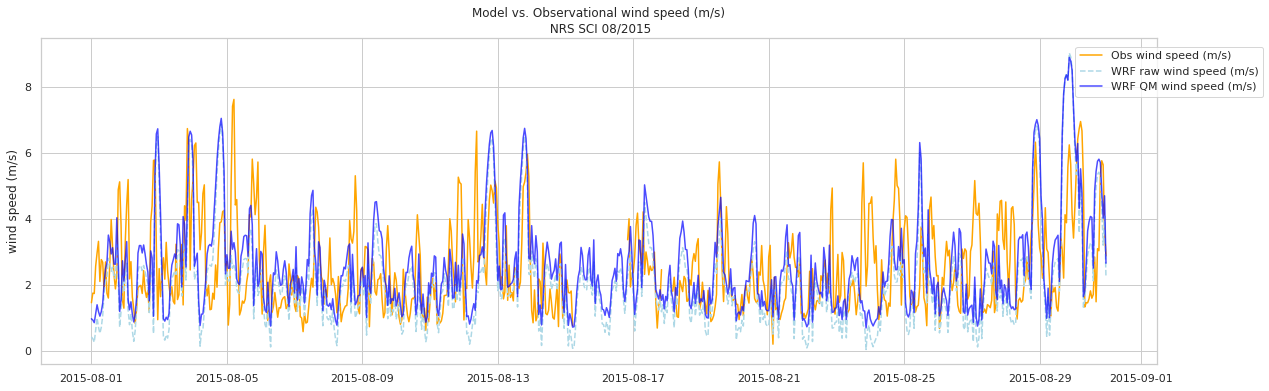

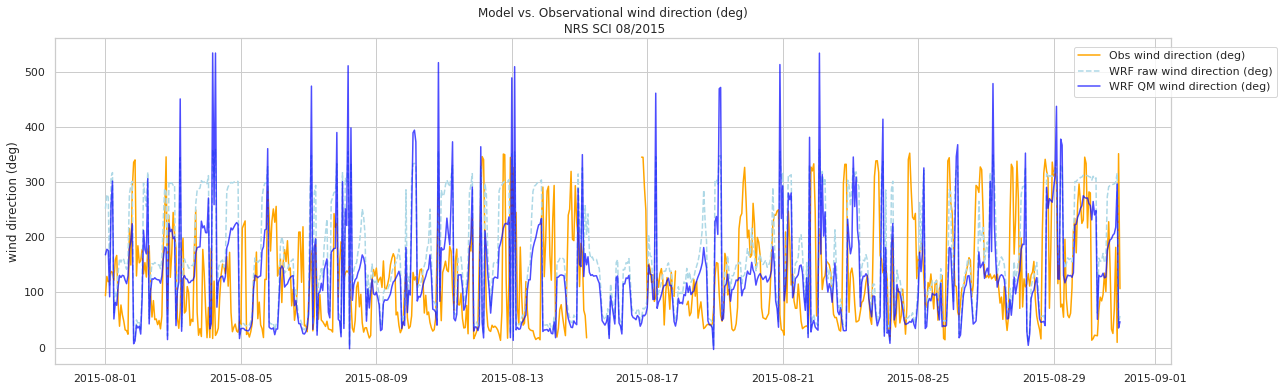

In [53]:
daterange = ['2008-08-01','2008-08-30']
nrs_daterange = ['2015-08-01', '2015-08-30']

for site in ['Sauces Canyon', 'Upper Embudo Canyon']:
    for var in variables:
        plot_timeseries(df, raw_df, var, daterange, site)
        
for var in variables:
    plot_timeseries(df, raw_df, var, nrs_daterange, 'NRS SCI')